# Model Training

### Idea 

Train a classification model using human radiograph images. We will then use class activation mapping to extract heatmaps to help localize any lesions.

For the dataset, labels were extracted from the radiologist report where: blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive. See [here](https://stanfordmlgroup.github.io/competitions/chexpert/)

### TODO 

- X Add learning rate scheduler to training. See keras options, and [this](https://www.jeremyjordan.me/nn-learning-rate/) blog post.
- X Add performance analysis
- X Add cutout augmentation as *last* augmentation. Do this in the other training notebook as well
- X Add class weights
- Add Lion optimizer
- Add error analysis
- Add k-fold cross validation
- See what happens if a portion of the model is frozen (e.g. freeze the weights half way through)
- Get heatmap piece at end working, so that you can visualize the argmax class of an image
----------------------------------------
- Move model performance code into it's own notebook/script
- Pull out preprocessing and metric functions into a utilities script

## Data Processing

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

from typing import List

from data_preparation import prepare_data

The code below can be used to verify that the gpu is in use

In [2]:
!nvidia-smi

Tue Jan 30 02:16:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti     Off | 00000000:01:00.0 Off |                  Off |
|  0%   27C    P8               4W / 450W |    221MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
TARGET_HEIGHT = 640
TARGET_WIDTH = 640

In [4]:
X_train, y_train, train_labels_df, targets = prepare_data(split='train')
X_val, y_val, valid_labels_df, _ = prepare_data(split='valid')

In [6]:
train_labels_df.shape

(223414, 37)

In [7]:
valid_labels_df.shape

(234, 37)

In [8]:
chexnet_targets = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

### Uncertainty Approaches
The CheXpert paper outlines several different approaches to mapping using the uncertainty labels in the data:

- Ignoring - essentially removing from the calculation in the loss function
- Binary mapping - sending uncertain values to either 0 or 1
- Prevalence mapping - use the rate of prevelance of the feature as it's target value
- Self-training - consider the uncertain values as unlabeled
- 3-Class Classification - retain a separate value for uncertain and try to predict it as a class in its own right

The paper gives the results of different experiments with the above approaches and indicates the most accurate approach for each feature.
    
|Approach/Feature|Atelectasis|Cardiomegaly|Consolidation|Edema|PleuralEffusion|
|-----------|-----------|-----------|-----------|-----------|-----------|
|`U-Ignore`|0.818(0.759,0.877)|0.828(0.769,0.888)|0.938(0.905,0.970)|0.934(0.893,0.975)|0.928(0.894,0.962)|
|`U-Zeros`|0.811(0.751,0.872)|0.840(0.783,0.897)|0.932(0.898,0.966)|0.929(0.888,0.970)|0.931(0.897,0.965)|
|`U-Ones`|**0.858(0.806,0.910)**|0.832(0.773,0.890)|0.899(0.854,0.944)|0.941(0.903,0.980)|0.934(0.901,0.967)|
|`U-Mean`|0.821(0.762,0.879)|0.832(0.771,0.892)|0.937(0.905,0.969)|0.939(0.902,0.975)|0.930(0.896,0.965)|
|`U-SelfTrained`|0.833(0.776,0.890)|0.831(0.770,0.891)|0.939(0.908,0.971)|0.935(0.896,0.974)|0.932(0.899,0.966)|
|`U-MultiClass`|0.821(0.763,0.879)|**0.854(0.800,0.909)**|0.937(0.905,0.969)|0.928(0.887,0.968)|0.936(0.904,0.967)|

The binary mapping approaches (U-Ones and U-Zeros) are easiest to implement and so to begin with we take the best option between U-Ones and U-Zeros for each feature

- Atelectasis `U-Ones`
- Cardiomegaly `U-Zeros`
- Consolidation `U-Zeros`
- Edema `U-Ones`
- Pleural Effusion `U-Zeros`

In [9]:
train_labels_df['valid'] = False
valid_labels_df['valid'] = True

In [10]:
full_df = pd.concat([train_labels_df, valid_labels_df], ignore_index=True)
full_df.head()

Path     Sex  Age  \
0  CheXpert-v1.0/train/patient00001/study1/view1_...  Female   68   
1  CheXpert-v1.0/train/patient00002/study2/view1_...  Female   87   
2  CheXpert-v1.0/train/patient00002/study1/view1_...  Female   83   
3  CheXpert-v1.0/train/patient00002/study1/view2_...  Female   83   
4  CheXpert-v1.0/train/patient00003/study1/view1_...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
3         Lateral   NaN         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   

   Lung Opacity  Lung Lesion  ...  Consolidation_u_zero  Pneumonia_u_zero  \
0           NaN          NaN  ...                     0                 0   
1           1.0          NaN  ...                     0                 0   
2           1.0          NaN  ...                     0                 0   
3           1.0          NaN  ...                     0                 0   
4           NaN          NaN  ...                     0                 0   

   Atelectasis_u_zero  Pneumothorax_u_zero  Pleural Effusion_u_zero  \
0                   0                    0                        0   
1                   0                    0                        0   
2                   0                    0                        0   
3                   0                    0                        0   
4                   0                    0                        0   

   Pleural Other_u_zero  Fracture_u_zero  Support Devices_u_zero  \
0                     0                0                       1   
1                     0                1                       0   
2                     0                1                       0   
3                     0                1                       0   
4                     0                0                       0   

                                                path  valid  
0  /data/CheXpert-v1.0/train/patient00001/study1/...  False  
1  /data/CheXpert-v1.0/train/patient00002/study2/...  False  
2  /data/CheXpert-v1.0/train/patient00002/study1/...  False  
3  /data/CheXpert-v1.0/train/patient00002/study1/...  False  
4  /data/CheXpert-v1.0/train/patient00003/study1/...  False  

[5 rows x 38 columns]

### View a sample of images and labels

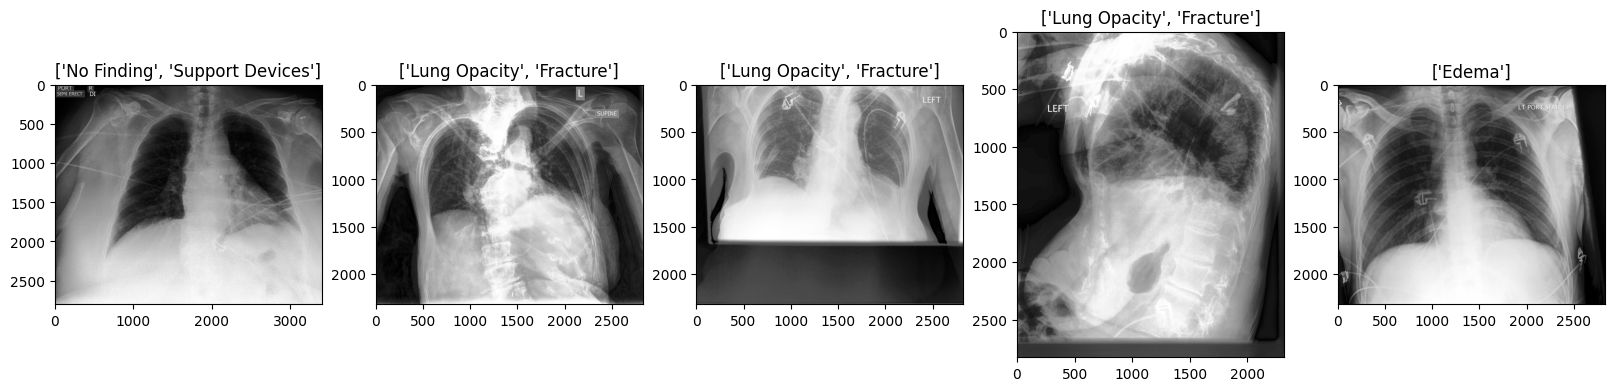

In [13]:
#get the first 5 images
paths =  full_df.path[:5]
labels = full_df.feature_string[:5]

fig, m_axs = plt.subplots(1, len(labels), figsize = (20, 10))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(np.asarray(Image.open(paths[ii])), cmap='gray')
    c_ax.set_title(labels[ii])
plt.show()

## Original Image

In [14]:
img = np.asarray(Image.open(X_val[0]))

In [15]:
img = np.stack((img,)*3, axis=-1)

In [16]:
img.shape

(2320, 2828, 3)

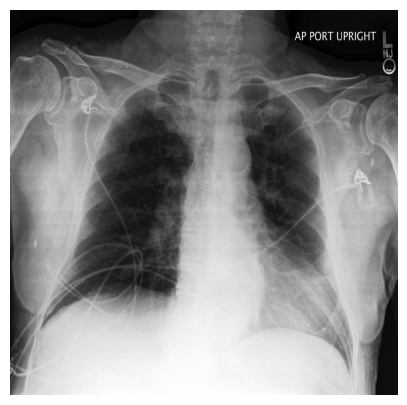

In [17]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(img)
ax.axis('off')
ax.set_aspect('auto')

plt.show() 

## Augmented Image

Most of the models test here are convolutional neural networks which have built-in translational equivariance as a result of the action of convolutional filters on the underlying image. This results in the classifier being translation invariant. However translation invariance is not the only invariance we would like our model to have, and for this reason it's important to have a large representative dataset so that many other invariances can be learned by the model during training. Augmentation is another way for us to help the model learn other invariances such as changes in brightness, saturation, contrast, etc.

In [18]:
def apply_mask(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = np.asarray(image.copy())
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2, x1:x2, :] = 0
    return new_image

In [19]:
if np.random.uniform() < 0.5:
    augmented = apply_mask(img, size=np.random.randint(low=70, high=240), n_squares=np.random.randint(low=2, high=12))
else:
    augmented = tf.image.random_brightness(img, max_delta=0.2)
    augmented = tf.image.random_saturation(image=augmented, lower=0.8, upper=1.2)
    augmented = tf.image.random_hue(image=augmented, max_delta=0.03)
    augmented = tf.image.random_contrast(image=augmented, lower=0.8, upper=1.2)
# augmented = tf.image.random_flip_up_down(img)
# augmented = tf.image.random_flip_left_right(img)
# augmented = tf.image.random_saturation(image=img, lower=0.7, upper=1.3)
# augmented = tf.image.random_hue(image=img, max_delta=0.03)
# augmented = tf.image.random_contrast(image=img, lower=0.7, upper=1.3)

In [20]:
augmented.shape

TensorShape([2320, 2828, 3])

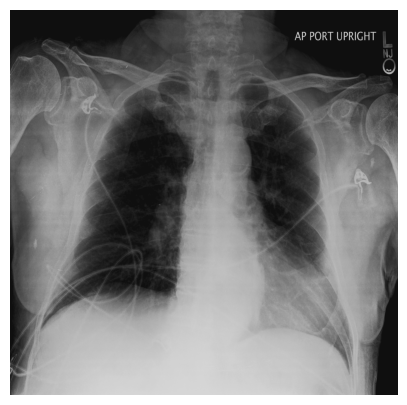

In [21]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(augmented, cmap='gray')
ax.axis('off')
ax.set_aspect('auto')

plt.show() 

In [22]:
NUM_TRAIN = len(X_train)

## Determine class weights

We often need to deal with an imbalance of classes in our dataset, especially if we want to get good recall on under represented classes. One way to do that is by using class weights so that a relatively higher loss is given on misclassifications of the under represented classes. The amount of class weighting, between none and emulating a uniform distribution, depends on the tradeoff between precision and recall for the classes. For this we will use log-scaled class weighting which will make a relatively slight adjustment toward a more uniform distribution.

In [23]:
target_columns = [col_name + '_label' for col_name in targets]

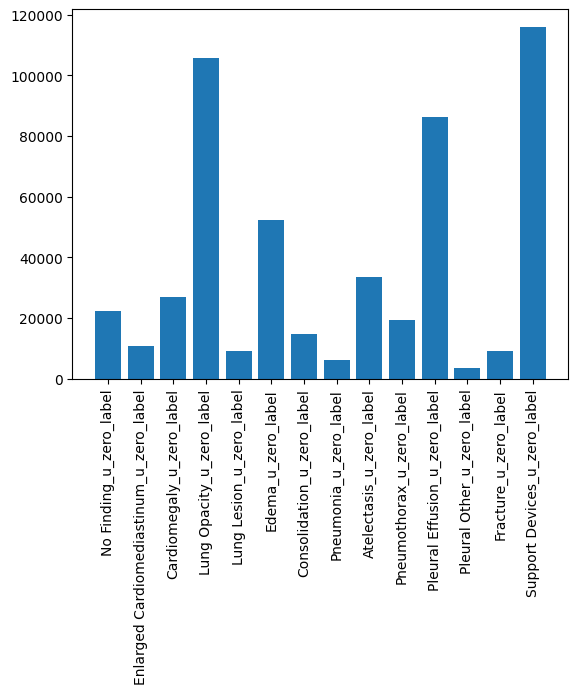

In [24]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train.sum(axis=0))
plt.show()

In [25]:
class_counts = y_train.sum(axis=0)
total_count = y_train.sum()

In [26]:
cls_weights = {i: total_count/class_i_count for i, class_i_count in enumerate(class_counts)}

In [27]:
cls_weights

{0: 23.03690630445467,
 1: 47.74856454899055,
 2: 19.09588888888889,
 3: 4.883350223998636,
 4: 56.127694317439584,
 5: 9.868487539715959,
 6: 34.8771561929243,
 7: 85.3765524093393,
 8: 15.447896692233941,
 9: 26.51115795968737,
 10: 5.982213094782276,
 11: 146.3494181095657,
 12: 57.034181415929204,
 13: 4.444694442289291}

In [28]:
cls_weights_sqrt = {i: np.sqrt(weight) for i, weight in enumerate(list(cls_weights.values()))}

In [29]:
cls_weights_sqrt

{0: 4.799677729228773,
 1: 6.91003361417226,
 2: 4.369884310698498,
 3: 2.209830360909777,
 4: 7.491841850802751,
 5: 3.1414148945524465,
 6: 5.905688460537374,
 7: 9.239943312019793,
 8: 3.9303812400623355,
 9: 5.148898713286888,
 10: 2.4458563111479537,
 11: 12.097496357080075,
 12: 7.552097815569473,
 13: 2.108244398140142}

In [30]:
cls_weights_log = {i: np.log(weight) for i, weight in enumerate(list(cls_weights.values()))}

In [31]:
cls_weights_log

{0: 3.137097551831732,
 1: 3.865949004673629,
 2: 2.9494730704653955,
 3: 1.585831505628296,
 4: 4.027629350566123,
 5: 2.289346603579213,
 6: 3.5518320645507715,
 7: 4.44707150114396,
 8: 2.7374728576513627,
 9: 3.277565699455902,
 10: 1.7887905822383254,
 11: 4.985997037110624,
 12: 4.0436507620656394,
 13: 1.4917111247108628}

In [32]:
y_train_weighted = y_train * np.array(list(cls_weights.values()))

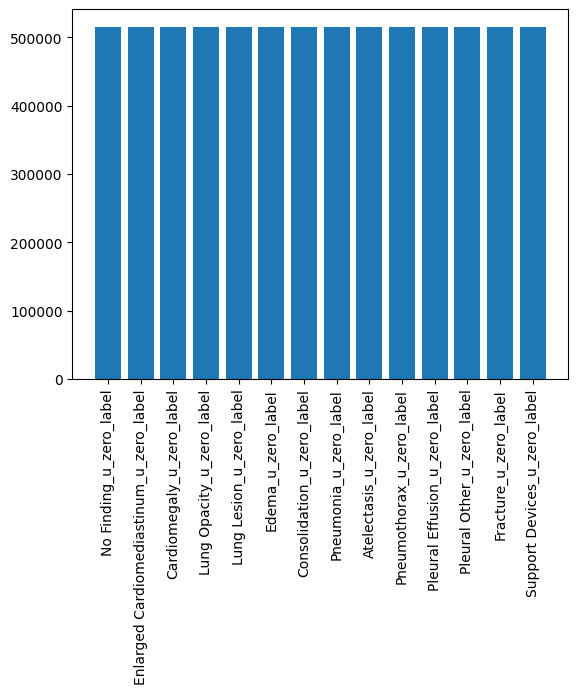

In [33]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train_weighted.sum(axis=0))
plt.show()

In [34]:
y_train_weighted_sqrt = y_train * np.array(list(cls_weights_sqrt.values()))

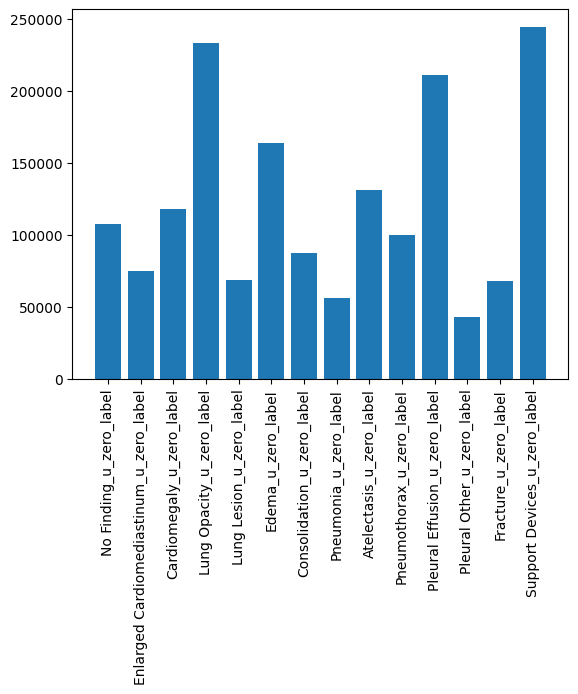

In [35]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train_weighted_sqrt.sum(axis=0))
plt.show()

In [36]:
y_train_weighted_log = y_train * np.array(list(cls_weights_log.values()))

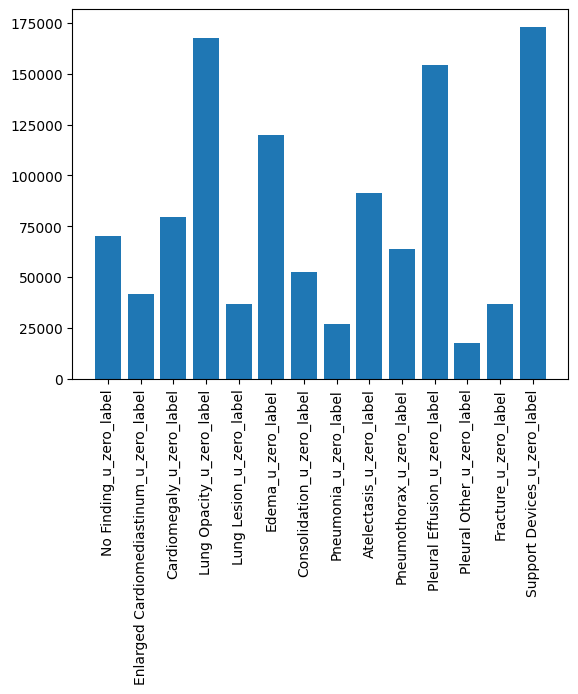

In [37]:
plt.xticks(rotation=90)
plt.bar(x=target_columns, height=y_train_weighted_log.sum(axis=0))
plt.show()

In [38]:
USE_CLASS_WEIGHTS = True

In [39]:
if USE_CLASS_WEIGHTS:
    CLASS_WEIGHTS = cls_weights_sqrt
else:
    CLASS_WEIGHTS = None

## Define dataset generator

In [40]:
def convert_image_to_array(path):
    img = np.asarray(Image.open(path), dtype=np.float32)
    img = np.stack((img,)*3, axis=-1)
    img /= 255.
    img = tf.image.resize_with_pad(img, target_height=TARGET_HEIGHT, target_width=TARGET_WIDTH)
    return img

In [41]:
def create_model_file(X_path, y):
    """
    X_path: (pandas series) contains the file paths to the images
    y: (pandas series of type int) the target label
    
    return a pair of numpy arrays representing (features, target)
    """
    
    X = pd.Series(X_path).apply(convert_image_to_array)
    X = X.values
    X = list(X)
    X = np.array(X, dtype='float32')
    
    return (X, y)

In [42]:
def model_predict(path, model):
    x = convert_image_to_array(path=path)
    x = np.expand_dims(x, axis=0)
    return model.predict(x)

In [43]:
val_data = create_model_file(X_path=X_val, y=y_val)

In [44]:
val_data[0].shape

(234, 640, 640, 3)

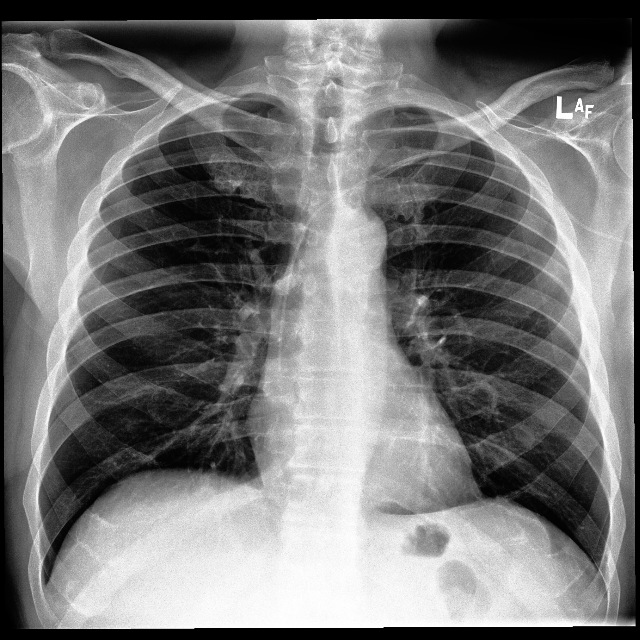

In [45]:
Image.fromarray(np.uint8(255 * val_data[0][1]))

In [46]:
num_classes = y_train.shape[1]

In [55]:
def transform_image(img_path, target_image_size, dtype, scale_image):
    # read the image
    img = np.asarray(Image.open(img_path), dtype=dtype)
    img = np.stack((img,)*3, axis=-1)

    # add image augmentation
    if np.random.uniform() < 0.6:
        img = apply_mask(img, size=np.random.randint(low=70, high=240), n_squares=np.random.randint(low=2, high=12))
    else:
        if np.random.uniform() < 0.15:
            img = tf.image.random_brightness(img, max_delta=0.2)
        if np.random.uniform() < 0.15:
            img = tf.image.random_saturation(image=img, lower=0.8, upper=1.2)
        if np.random.uniform() < 0.15:
            img = tf.image.random_hue(image=img, max_delta=0.03)
        if np.random.uniform() < 0.15:
            img = tf.image.random_contrast(image=img, lower=0.8, upper=1.2)

    if scale_image:
        img = img/255.

    # resize image
    img = tf.image.resize_with_pad(img, target_height=target_image_size[0], target_width=target_image_size[1])
    
    return img

#### Visualize some transformed images 

In [66]:
img_path = X_val[1]

Original

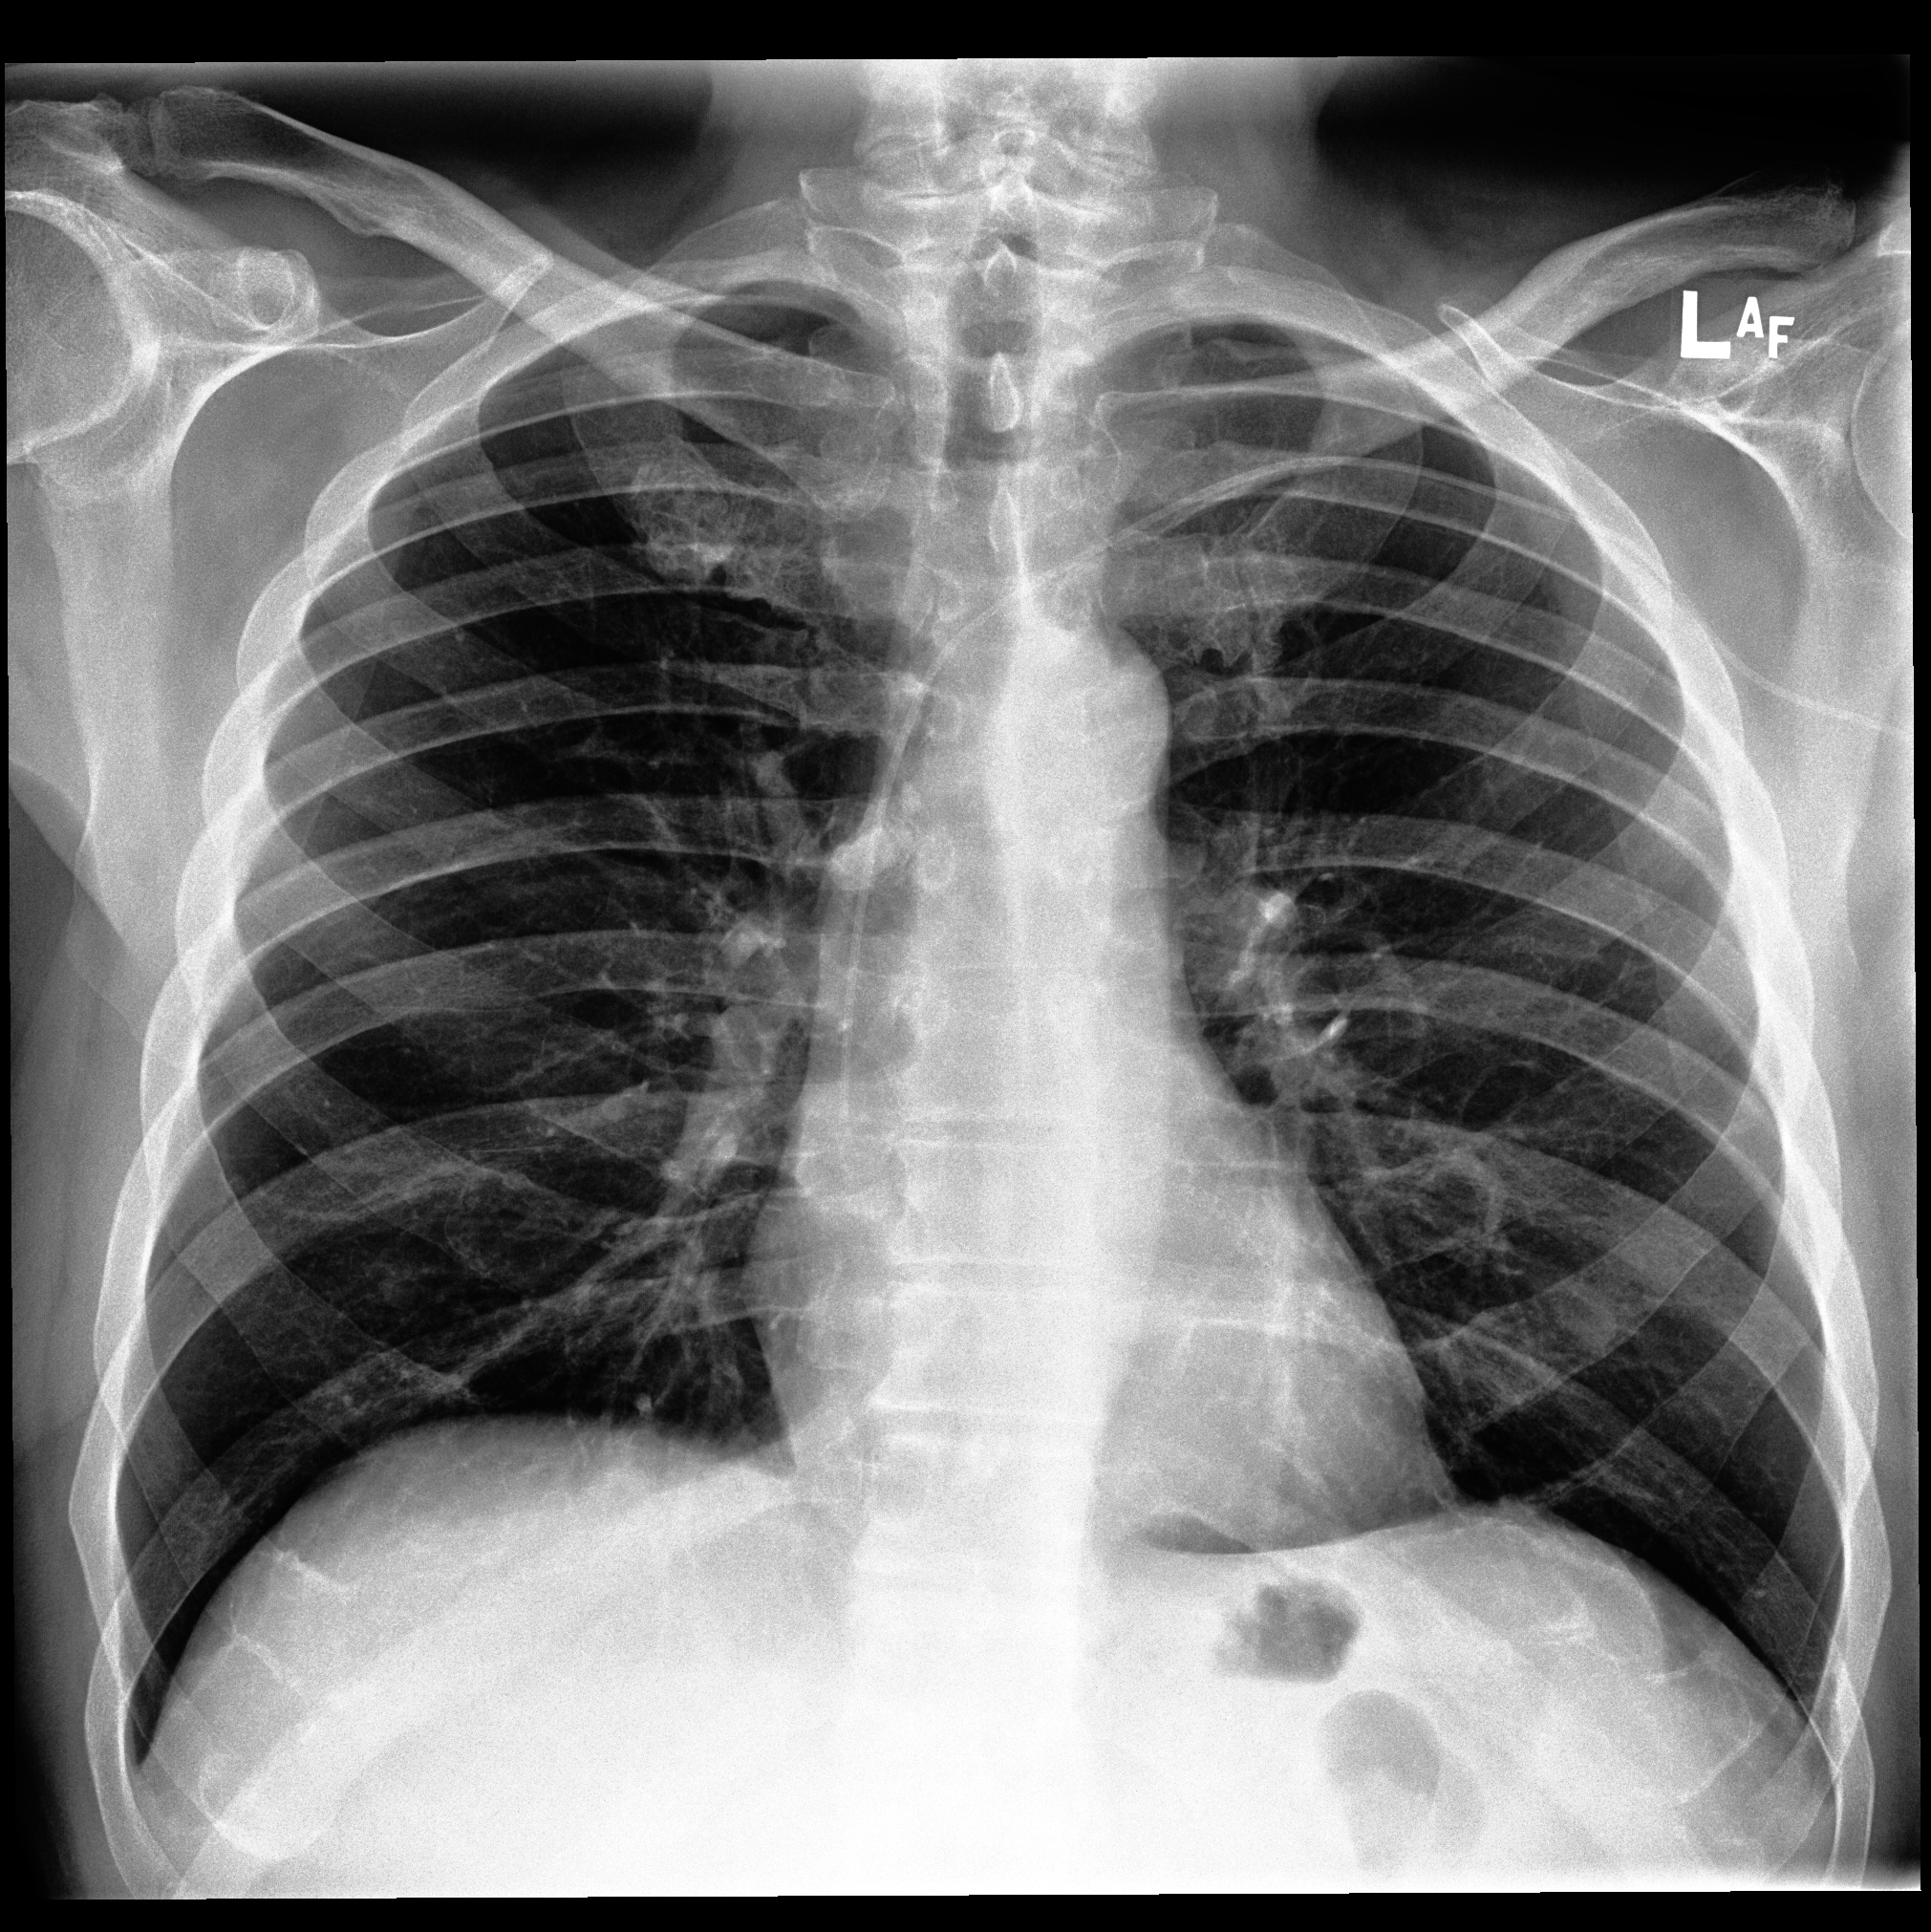

In [67]:
Image.open(img_path)

In [78]:
img = transform_image(img_path=img_path, target_image_size=(TARGET_HEIGHT, TARGET_WIDTH), dtype=np.float32, scale_image=True)

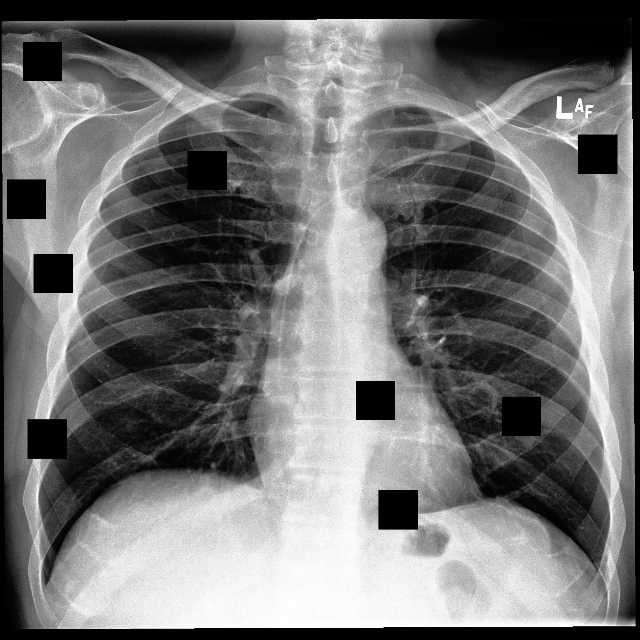

In [79]:
Image.fromarray(np.uint8(255 * img.numpy()))

In [80]:
def data_gen(X, y, batch_size, image_size=(TARGET_HEIGHT, TARGET_WIDTH), dtype=np.float32, scale_image=True):
    # Get total number of samples in the data
    n = len(X)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, image_size[0], image_size[1], 3), dtype=dtype)
    batch_labels = np.zeros((batch_size, num_classes), dtype=dtype)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_path = X[idx]
            label = y[idx]
            
            # one hot encoding
            encoded_label = label
            
            # Transform/augment the image
            img = transform_image(img_path=img_path, target_image_size=image_size, dtype=dtype, scale_image=scale_image)
            
            batch_data[count] = img
            batch_labels[count] = encoded_label

            count+=1

            if count==batch_size:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

## Keras Utility Functions

Define some functions that will help simplify the fine-tuning pre-trained models

In [81]:
def freeze_layers(model, freeze_layer_name):
    for layer in model.layers:
        if layer.name != freeze_layer_name:
            layer.trainable = False
        else:
            layer.trainable = False
            break
            
def unfreeze_batch_norm(model):
    for layer in model.layers:
        if layer.__class__.__name__ == 'BatchNormalization':
            layer.trainable = True
            
def unfreeze_layer_norm(model):
    for layer in model.layers:
        if layer.__class__.__name__ == 'LayerNormalization':
            layer.trainable = True

def print_layer_trainable(model):
    for layer in model.layers:
        print('{0}:\t{1}'.format(layer.trainable, layer.name))

## (Optional) Load pretrained model

In [87]:
from keras.applications.convnext import LayerScale

In [88]:
# List all models
!ls ../models

model_ConvNeXtBase_w_ClssWgt_03-0.3726.h5
pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3616.h5
pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3887.h5
pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.4021.h5
pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.4813.h5
pretrain_model_ConvNeXtBase_w_ClssWgt_02-0.4721.h5
pretrain_model_ConvNeXtSmall_w_ClssWgt_02-0.4580.h5
pretrain_model_ConvNeXtSmall_w_ClssWgt_03-0.5216.h5


In [89]:
MODEL_NAME = 'pretrain_model_ConvNeXtBase_w_ClssWgt_02-0.4721.h5'
model_path = f'../models/{MODEL_NAME}'
model = tf.keras.models.load_model(model_path, custom_objects={'LayerScale': LayerScale})

In [90]:
model.summary()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageInput (InputLayer)        [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_prestem_normaliz  (None, 640, 640, 3)  0          ['ImageInput[0][0]']             
 ation (Normalization)                                                                            
                                                                                                  
 convnext_base_stem (Sequential  (None, 160, 160, 12  6528       ['convnext_base_prestem_normaliza
 )                              8)                               tion[0][0]']              

 tf.__operators__.add_2 (TFOpLa  (None, 160, 160, 12  0          ['tf.__operators__.add_1[0][0]', 
 mbda)                          8)                                'convnext_base_stage_0_block_2_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_downsampling_blo  (None, 80, 80, 256)  131584     ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 80, 80, 256)  12800      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_0[0][0]']                      
                                                                                                  
 convnext_

 convnext_base_downsampling_blo  (None, 40, 40, 512)  525312     ['tf.__operators__.add_5[0][0]'] 
 ck_1 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 512)  25600      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_1[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_0_l
 pointwise

 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_3_l
 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_3_p
 gelu (Activation)              )                                ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_3_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
          

 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_6_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_6_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_6_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_11[0][0]',
 ambda)   

                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_14[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_9_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 512)  25600      ['tf.__operators__.add_15[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_10_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )        

 convnext_base_stage_2_block_13  (None, 40, 40, 512)  25600      ['tf.__operators__.add_18[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_13  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_13_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_13_
 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_

 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_16_
 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_16_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_16_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
          

 convnext_base_stage_2_block_19  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_19_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_19_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_19_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_19_
 _identity

                                                                                                  
 convnext_base_stage_2_block_22  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_22_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_22  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_22_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_28 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_27[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_22_
                                                                 identity[0][0]']                 
          

 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_31 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_30[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_25_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_26  (None, 40, 40, 512)  25600      ['tf.__operators__.add_31[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_26  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_26_
 _layernor

 ambda)                         )                                 'convnext_base_stage_3_block_1_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 1024  51200      ['tf.__operators__.add_34[0][0]']
 depthwise_conv (Conv2D)        )                                                                 
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 1024  2048       ['convnext_base_stage_3_block_2_d
 layernorm (LayerNormalization)  )                               epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 4096  4198400    ['convnext_base_stage_3_block_2_l
 pointwise

In [92]:
model.trainable = True

In [93]:
print_layer_trainable(model)

True:	ImageInput
True:	convnext_base_prestem_normalization
True:	convnext_base_stem
True:	convnext_base_stage_0_block_0_depthwise_conv
True:	convnext_base_stage_0_block_0_layernorm
True:	convnext_base_stage_0_block_0_pointwise_conv_1
True:	convnext_base_stage_0_block_0_gelu
True:	convnext_base_stage_0_block_0_pointwise_conv_2
True:	convnext_base_stage_0_block_0_layer_scale
True:	convnext_base_stage_0_block_0_identity
True:	tf.__operators__.add
True:	convnext_base_stage_0_block_1_depthwise_conv
True:	convnext_base_stage_0_block_1_layernorm
True:	convnext_base_stage_0_block_1_pointwise_conv_1
True:	convnext_base_stage_0_block_1_gelu
True:	convnext_base_stage_0_block_1_pointwise_conv_2
True:	convnext_base_stage_0_block_1_layer_scale
True:	convnext_base_stage_0_block_1_identity
True:	tf.__operators__.add_1
True:	convnext_base_stage_0_block_2_depthwise_conv
True:	convnext_base_stage_0_block_2_layernorm
True:	convnext_base_stage_0_block_2_pointwise_conv_1
True:	convnext_base_stage_0_block_2_

## Build the model

TODO Add in MobileNetV2, EfficientNet (this requires tensorflow 2.2 nightly update import once this is in stable release), DenseNet

In [82]:
# from tensorflow.keras.applications.xception import Xception

# input_tensor = layers.Input(shape=(450, 600, 3), name='ImageInput')

# model = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [83]:
# Note: Expected input from B5, B6, B7 are 456x456, 528x528, 600x600
# from tensorflow.python.keras.applications.efficientnet import EfficientNetB6

# input_tensor = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), name='ImageInput')

# model = EfficientNetB6(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [84]:
# from tensorflow.keras.applications.resnet_v2 import ResNet101V2

# input_tensor = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), name='ImageInput')

# model = ResNet101V2(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [85]:
# from tensorflow.keras.applications.densenet import DenseNet201

# input_tensor = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), name='ImageInput')

# model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [86]:
# from tensorflow.keras.applications import ConvNeXtSmall

# input_tensor = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), name='ImageInput')

# model = ConvNeXtSmall(include_top=False, weights='imagenet', input_tensor=input_tensor, include_preprocessing=False)

In [ ]:
from tensorflow.keras.applications import ConvNeXtBase

input_tensor = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3), name='ImageInput')

# model = ConvNeXtBase(include_top=False, weights='imagenet', input_tensor=input_tensor, include_preprocessing=False)
model = ConvNeXtBase(include_top=False, weights='imagenet', input_tensor=input_tensor, include_preprocessing=True)

In [ ]:
model.summary()

Determine where to freeze and cut off base model

In [ ]:
# Note: these were used to train Xception
# transfer_layer_name = 'block14_sepconv1_act'
# freeze_layer_name = 'add_10'

# transfer_layer = model.get_layer(transfer_layer_name)

In [ ]:
# Note: these were used to train EfficientNet
# transfer_layer_name = 'block7c_add'
# freeze_layer_name = 'block6k_add'

# transfer_layer = model.get_layer(transfer_layer_name)

In [ ]:
# Note: these were used to train ResNet101V2
# transfer_layer_name = 'post_relu'
# freeze_layer_name = 'conv5_block1_out'

# transfer_layer = model.get_layer(transfer_layer_name)

In [ ]:
# Note: these were used to train DenseNet201
# transfer_layer_name = 'relu'
# # freeze_layer_name = 'conv5_block27_concat'

# transfer_layer = model.get_layer(transfer_layer_name)

In [ ]:
# # Note: these were used to train ConvNeXtSmall
# transfer_layer_name = 'layer_normalization'
# freeze_layer_name = 'tf.__operators__.add_33'

# transfer_layer = model.get_layer(transfer_layer_name)

In [ ]:
# # Note: these were used to train ConvNeXtBase
# Idea: fine tune the last few layers, then retrain with entire model unfrozen
transfer_layer_name = 'layer_normalization'
freeze_layer_name = 'layer_normalization'
# freeze_layer_name = 'tf.__operators__.add_21' # tf.__operators__.add_17, tf.__operators__.add_21, tf.__operators__.add_26, tf.__operators__.add_31
# consider using smaller input image 512 x 512 and retrain more 
transfer_layer = model.get_layer(transfer_layer_name)

In [ ]:
# model.summary()

In [ ]:
conv_model = tf.keras.Model(inputs=model.input, outputs=transfer_layer.output)

In [ ]:
def build_model(base_model, num_classes, pooling='avg', final_conv_layer='vgg_separable', expand_model=True, dropout_rate=0):
    # Get the output of the base model on which we will build
    x = base_model.layers[-1].output
    
    if expand_model:
        if final_conv_layer == 'xception':
            x = layers.SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
            x = layers.BatchNormalization(name='block14_sepconv2_bn')(x)
            x = layers.Activation('relu', name='block14_sepconv2_act')(x)
        elif final_conv_layer == 'non_separable':
            x = layers.Conv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_conv2')(x)
            x = layers.BatchNormalization(name='block14_conv2_bn')(x)
            x = layers.Activation('relu', name='block14_conv2_act')(x)
        elif final_conv_layer == 'vgg_separable':
            x = layers.SeparableConv2D(2048, (3,3), activation='relu', padding='same', name='block14_sepconv2')(x)
        elif final_conv_layer == 'vgg':
            x = layers.Conv2D(2048, (3,3), activation='relu', padding='same', name='block14_sepconv2')(x)
        else:
            raise ValueError('`final_conv_layer` should be one of the following: xception, non_separable, vgg_separable, or vgg')

    if pooling == 'global_avg':
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'global_max':
        x = layers.GlobalMaxPooling2D(name='global_max_pool')(x)
    elif pooling == 'max':
        x = layers.MaxPooling2D((2,2), name='local_max_pool')(x)
        x = layers.Flatten(name='flatten')(x)
    elif pooling == 'avg':
        x = layers.AveragePooling2D((2,2), name='local_avg_pool')(x)
        x = layers.Flatten(name='flatten')(x)
    else:
        pass
    x = keras.layers.Dropout(dropout_rate)(x)
        
    x = layers.Dense(num_classes, activation='sigmoid', name='prediction')(x)

    # Create model.
    model = tf.keras.Model(base_model.input, x, name='Xception')
    return model

## Determine good starting learning rate

Experiment with the proper learning rate range by starting at a low number, see how many epochs for loss to get to a certain value, incrementally increase until the learning rate is too high. Use this range to determine the initial learning rate.

Create a function to do this analysis

In [94]:
# local_model = ConvNeXtBase(include_top=False, weights='imagenet', input_tensor=input_tensor, include_preprocessing=True)
# local_conv_model = tf.keras.Model(inputs=local_model.input, outputs=local_model.output)

# model_lr = build_model(base_model=local_conv_model, num_classes=num_classes, dropout_rate=0.3)

In [95]:
def determine_learning_rate(model, X, y, batch_size: int, lr_list: List[float], steps: int):
    train_loss_by_lr = []
    
    for i, lr in enumerate(lr_list):
        print(f'Learning rate {i + 1} of {len(lr_list)}. LR value: {lr}')
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss="binary_crossentropy",
            metrics=["accuracy"],
        )
        
        hist = model.fit(
            x=data_gen(X=X, y=y, batch_size=batch_size, scale_image=False), 
            epochs=1, 
            steps_per_epoch=steps,
            class_weight=CLASS_WEIGHTS,
        )
        
        final_loss = hist.history['loss'][-1]
        final_acc = hist.history['accuracy'][-1]
        
        train_loss_by_lr.append((lr, final_loss, final_acc))
      
    losses_df = pd.DataFrame(train_loss_by_lr, columns=['learning_rate', 'training_loss', 'training_accuracy'])
    
    return losses_df

In [ ]:
lr_loss_df = determine_learning_rate(model=model,
                                     X=X_train, 
                                     y=y_train, 
                                     batch_size=2, 
                                     lr_list=[1e-1, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7, 1e-8,],
                                     steps=200)

Learning rate 1 of 12. LR value: 0.1
200/200 [==============================] - 93s 289ms/step - loss: 1.4338 - accuracy: 0.0600
Learning rate 2 of 12. LR value: 0.01
200/200 [==============================] - 95s 295ms/step - loss: 1.4265 - accuracy: 0.0375
Learning rate 3 of 12. LR value: 0.005
200/200 [==============================] - 93s 292ms/step - loss: 1.3365 - accuracy: 0.0500
Learning rate 4 of 12. LR value: 0.001
200/200 [==============================] - 93s 291ms/step - loss: 1.2802 - accuracy: 0.0425
Learning rate 5 of 12. LR value: 0.0005
 49/200 [======>.......................] - ETA: 38s - loss: 1.5000 - accuracy: 0.0204

In [ ]:
plt.scatter(x=lr_loss_df['learning_rate'].values, y=lr_loss_df['training_loss'].values)
plt.xscale('log')
plt.show()

## Train model

In [ ]:
# Ideally retrain the entire model, but memory is constrained 
freeze_layers(conv_model, freeze_layer_name)

In [ ]:
model = build_model(base_model=conv_model, num_classes=num_classes, dropout_rate=0.3)

In [ ]:
# model.summary()

In [ ]:
unfreeze_batch_norm(model)

In [ ]:
unfreeze_layer_norm(model)

In [ ]:
print_layer_trainable(model)

### Load Pretrained Model (alternative)

In [ ]:
# model_path='./serialized_models/pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3887.h5'
# model_path='./serialized_models/pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.4021.h5'
# model_path='./serialized_models/pretrain_model_ConvNeXtSmall_w_ClssWgt_03-0.5216.h5'

In [ ]:
# from keras.applications.convnext import LayerScale
# model = tf.keras.models.load_model(model_path, custom_objects={'LayerScale': LayerScale})

In [ ]:
print_layer_trainable(model)

## Train the model

In [ ]:
lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
      initial_learning_rate=3e-3,
      first_decay_steps=7979)

In [ ]:
# Cycle through cosine decay with restarts 7 times per epoch
7979 == 55853 / 7

In [ ]:
epochs = 2
batch_size = 4
model_path='../models/pretrain_model_ConvNeXtBase_w_ClssWgt_{epoch:02d}-{val_loss:.4f}.h5'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=model_path, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3),
    tf.keras.callbacks.EarlyStopping(patience=10)
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    x=data_gen(X=X_train, y=y_train, batch_size=batch_size, scale_image=False), 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=val_data, 
    steps_per_epoch=int(NUM_TRAIN/batch_size),
    class_weight=CLASS_WEIGHTS,
)

13300/55853, loss: 0.3006, accuracy: 0.2011
7364/55853, loss: 1.2744, accuracy: 0.0874 (using built-in preprocessing rather than scaling)

Save final model - Make sure name is correct!

In [ ]:
model.save('./serialized_models/pretrain_model_ConvNeXtBase_w_ClssWgt_04-0.4061.h5')